In [2]:
! pip install torch_geometric networkx matplotlib torch torchvision torch-geometric torchsummary layers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 680.1 kB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.0 MB/s eta 0:00:0000:0100:01
  Created wheel for layers: filename=layers-0.1.5-py3-none-any.whl size=5355 sha256=52e2527433464c5c068a3c067b80599956d023420d0b16f1941dac365dda09a8
  Stored in directory: /root/.cache/pip/wheels/68/7e/9a/eef1bfd14949d8154d75aaa90cb20916e5b3e706ccab344690
  Created wheel for bashutils: filename=Bashutils-0.0.4-py3-none-any.whl size=5459 sha256=0cfbe80a554f7a84d9d53af47d7195f85844b5cb316fb11d14af5973f907319b
  Stored in directory: /root/.cache/pip/wheels/25/49/d6/964f90673b8cb71f4a9fd6b19fdf69321c355bc1b48b0b5094
Successfully built layers bashutils


In [3]:
import json
from torchsummary import summary
import os
import networkx as nx
import torch
from torch_geometric.utils import from_networkx
from torch_geometric.data import Data, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch.utils.data import random_split

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# function to load json
def load_json(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

# make graph
def build_graph(data):
    G = nx.DiGraph()

    # add  root tweet
    root_id = data['id']
    G.add_node(root_id, **data)
    
    # recursive function to add children
    def add_children(children, parent_id):
        for child in children:
            G.add_node(child['id'], **child)
            G.add_edge(parent_id, child['id'])
            if 'children' in child:
                add_children(child['children'], child['id'])
    
    if 'children' in data:
        add_children(data['children'], root_id)
    
    return G


# function to normalize node attributes
def normalize_node_attributes(graph):
    all_attributes = set()
    for _, attrs in graph.nodes(data=True):
        all_attributes.update(attrs.keys())
    for node, attrs in graph.nodes(data=True):
        for attr in all_attributes:
            if attr not in attrs:
                attrs[attr] = None
    return graph


# adjusted convert to data
# added node degree and clustering coefficient as node features
def convert_to_data(graph, label):
    data = from_networkx(graph)
    
    # give more informative signals than all ones
    if not hasattr(data, 'x') or data.x is None:
        num_nodes = data.num_nodes
        degrees = torch.tensor([degree for _, degree in graph.degree()], dtype=torch.float).view(-1, 1)
        clustering = torch.tensor([nx.clustering(graph, node) for node in graph.nodes], dtype=torch.float).view(-1, 1)
        data.x = torch.cat([degrees, clustering], dim=1)
    
    data.y = torch.tensor([label] * data.num_nodes, dtype=torch.long)
    return data


path = '/kaggle/input/test-network/nx_network_data/' # change to individual path


def create_json_dict(base_path):
    json_dict = {}
    
    for label in ['gossipcop_fake', 'gossipcop_real']:
        folder_path = os.path.join(base_path, label)
        files = os.listdir(folder_path)
        files = [f for f in files if f.endswith('.json')]
        for file in files:  
            print(file)
            json_dict[os.path.join(label, file)] = 'fake' if label in ['gossipcop_fake'] else 'real'
    
    return json_dict

json_dict = create_json_dict(path)

full_dataset = []

# loop to create mega dataset
for dataset in list(json_dict.keys()):
    file = load_json(path + dataset)
    graph = normalize_node_attributes(build_graph(file))
    data = convert_to_data(graph, 1) if json_dict[dataset] == 'fake' else convert_to_data(graph, 0)
    full_dataset.append(data)


politifact695.json
politifact11189.json
politifact370.json
politifact806.json
politifact7665.json
politifact12079.json
politifact215.json
politifact9438.json
politifact11709.json
politifact1361.json
politifact10945.json
politifact304.json
politifact7540.json
politifact384.json
politifact7489.json
politifact13855.json
politifact14511.json
politifact6998.json
politifact1467.json
politifact11899.json
politifact780.json
politifact11416.json
politifact720.json
politifact15319.json
politifact8071.json
politifact100.json
politifact6556.json
politifact12120.json
politifact426.json
politifact979.json
politifact4181.json
politifact3198.json
politifact14940.json
politifact1314.json
politifact1106.json
politifact11208.json
politifact74.json
politifact12052.json
politifact4080.json
politifact6537.json
politifact11191.json
politifact10731.json
politifact93.json
politifact7968.json
politifact10903.json
politifact539.json
politifact12418.json
politifact9512.json
politifact228.json
politifact8537.json


In [30]:
full_dataset

[Data(edge_index=[2, 5], time=[6], type=[6], user=[6], tweet_id=[6], id=[6], children=[6], bot_score=[6], sentiment=[6], num_nodes=6, x=[6, 2], y=[6]),
 Data(edge_index=[2, 302], time=[303], type=[303], user=[303], tweet_id=[303], id=[303], children=[303], bot_score=[303], sentiment=[303], num_nodes=303, x=[303, 2], y=[303]),
 Data(edge_index=[2, 2430], time=[2431], type=[2431], user=[2431], tweet_id=[2431], id=[2431], children=[2431], bot_score=[2431], sentiment=[2431], num_nodes=2431, x=[2431, 2], y=[2431]),
 Data(edge_index=[2, 19], time=[20], type=[20], user=[20], tweet_id=[20], id=[20], children=[20], bot_score=[20], num_nodes=20, x=[20, 2], y=[20]),
 Data(edge_index=[2, 14], time=[15], type=[15], user=[15], tweet_id=[15], id=[15], children=[15], bot_score=[15], num_nodes=15, x=[15, 2], y=[15]),
 Data(edge_index=[2, 3434], time=[3435], type=[3435], user=[3435], tweet_id=[3435], id=[3435], children=[3435], bot_score=[3435], sentiment=[3435], num_nodes=3435, x=[3435, 2], y=[3435]),


Number of Graphs: 11257
Number of fake news graphs: 4035
Number of real news graphs: 7222


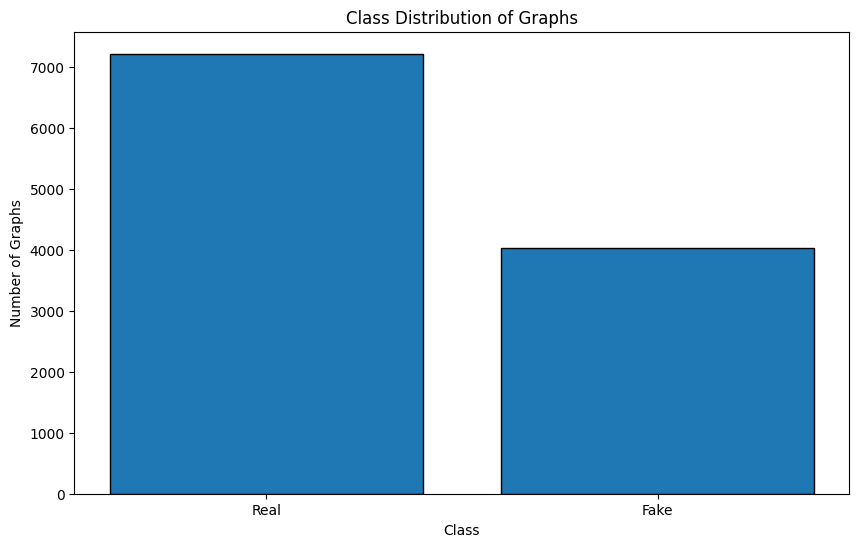

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Count the number of fake and real news graphs
fake_count = 0
real_count = 0

for data in full_dataset:
    label = data.y[0].item()  # Get the label for the first node
    if label == 1:
        fake_count += 1
    elif label == 0:
        real_count += 1

# Print the counts
print(f'Number of Graphs: {len(full_dataset)}')
print(f'Number of fake news graphs: {fake_count}')
print(f'Number of real news graphs: {real_count}')

# Prepare data for histogram
labels = [0] * real_count + [1] * fake_count
label_names = ['Real', 'Fake']

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.hist(labels, bins=np.arange(-0.5, 2, 1), edgecolor='black', rwidth=0.8)
plt.xticks([0, 1], label_names)
plt.xlabel('Class')
plt.ylabel('Number of Graphs')
plt.title('Class Distribution of Graphs')
plt.show()


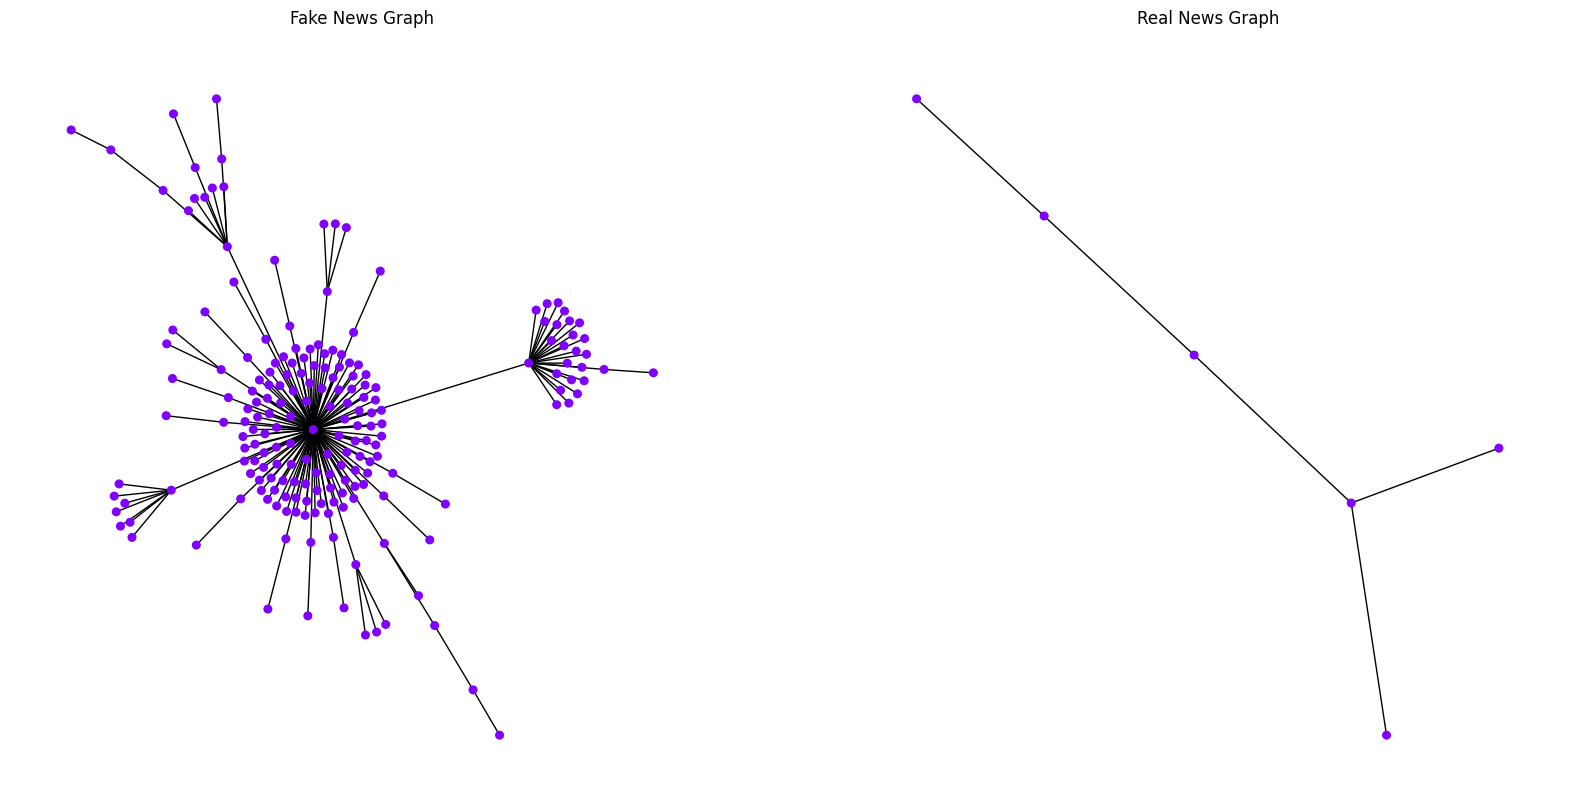

In [8]:
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx

# Find one fake news graph and one real news graph
fake_data = next(data for data in full_dataset if data.y[0].item() == 1)
real_data = next(data for data in full_dataset if data.y[0].item() == 0)

# Convert to NetworkX graphs and find their largest connected components
def get_largest_wcc(data):
    G = to_networkx(data, to_undirected=True)
    largest_wcc = max(nx.connected_components(G), key=len)
    return G.subgraph(largest_wcc).copy()

G_fake = get_largest_wcc(fake_data)
G_real = get_largest_wcc(real_data)

# Define the layout for both graphs
pos_fake = nx.spring_layout(G_fake)
pos_real = nx.spring_layout(G_real)

# Create a figure with two subplots
plt.figure(figsize=(20, 10))

# Plot fake news graph
plt.subplot(1, 2, 1)
nx.draw(
    G_fake, 
    pos_fake, 
    node_size=30, 
    node_color=[fake_data.y[i].item() for i in G_fake.nodes()],
    cmap=plt.cm.rainbow, 
    with_labels=False, 
    arrows=True
)
plt.title('Fake News Graph')

# Plot real news graph
plt.subplot(1, 2, 2)
nx.draw(
    G_real, 
    pos_real, 
    node_size=30, 
    node_color=[real_data.y[i].item() for i in G_real.nodes()],
    cmap=plt.cm.rainbow, 
    with_labels=False, 
    arrows=True
)
plt.title('Real News Graph')

# Show the plot
plt.show()

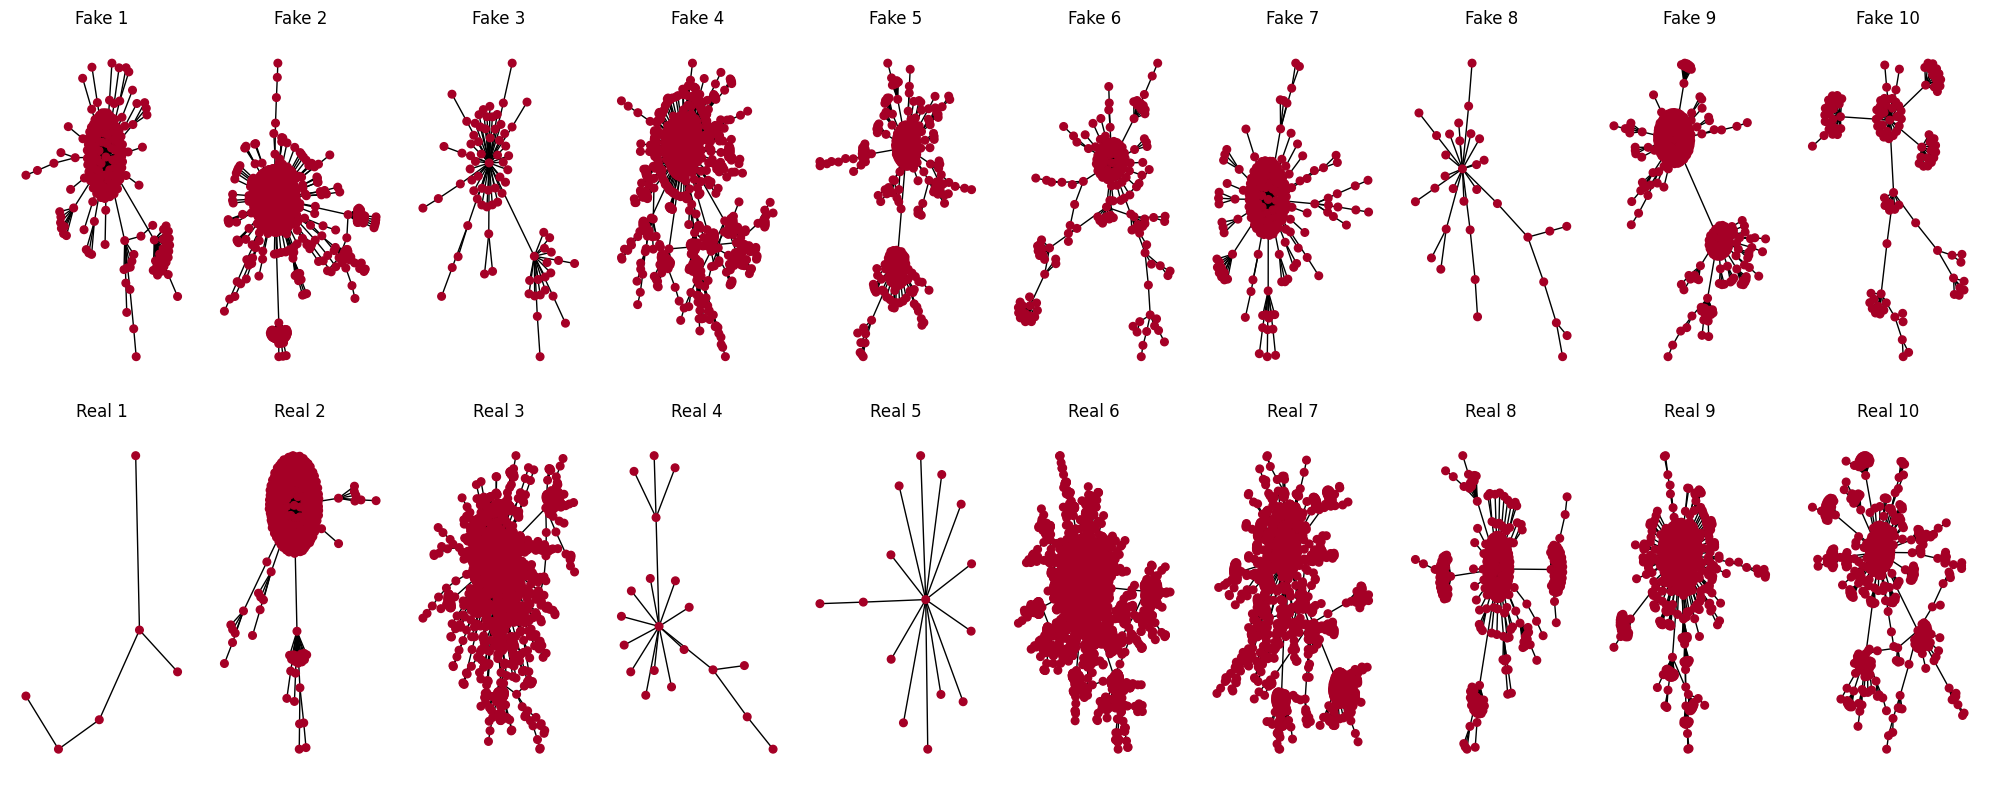

In [9]:
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx

# Extract 10 fake and 10 real news graphs from the dataset
fake_graphs = [data for data in full_dataset if data.y[0].item() == 1][:10]
real_graphs = [data for data in full_dataset if data.y[0].item() == 0][:10]

# Create a figure with subplots
fig, axs = plt.subplots(2, 10, figsize=(20, 8)) 

# Define layout for plotting
for i, (fake_data, real_data) in enumerate(zip(fake_graphs, real_graphs)):
    # Plot fake news graph
    G_fake = to_networkx(fake_data, to_undirected=True)
    pos_fake = nx.spring_layout(G_fake, seed=42)
    nx.draw(
        G_fake,
        pos_fake,
        ax=axs[0, i],
        node_size=30,
        node_color=[fake_data.y[i].item() for i in G_fake.nodes()],
        cmap=plt.cm.RdYlBu,
        with_labels=False,
        arrows=False
    )
    axs[0, i].set_title(f'Fake {i+1}')
    axs[0, i].axis('off')  # Hide axes

    # Plot real news graph
    G_real = to_networkx(real_data, to_undirected=True)
    pos_real = nx.spring_layout(G_real, seed=42)
    nx.draw(
        G_real,
        pos_real,
        ax=axs[1, i],
        node_size=30,
        node_color=[real_data.y[i].item() for i in G_real.nodes()],
        cmap=plt.cm.RdYlBu,
        with_labels=False,
        arrows=False
    )
    axs[1, i].set_title(f'Real {i+1}')
    axs[1, i].axis('off')  # Hide axes

plt.tight_layout()
plt.show()

In [10]:
import pandas as pd
import torch

def create_dataframe_from_data(data):
    # Convert each attribute to a list or numpy array if needed
    # Handle edge_index
    edge_index = data.edge_index.numpy().T.tolist()  # Transpose and convert to list of lists
    
    # Handle time
    if isinstance(data.time, torch.Tensor):
        time = data.time.numpy().tolist()
    elif isinstance(data.time, list):
        time = data.time
    else:
        time = []
    
    # Handle type
    if isinstance(data.type, torch.Tensor):
        type_ = data.type.numpy().tolist()
    elif isinstance(data.type, list):
        type_ = data.type
    else:
        type_ = []
    
    # Handle user
    if isinstance(data.user, torch.Tensor):
        user = data.user.numpy().tolist()
    elif isinstance(data.user, list):
        user = data.user
    else:
        user = []
    
    # Handle tweet_id
    if isinstance(data.tweet_id, torch.Tensor):
        tweet_id = data.tweet_id.numpy().tolist()
    elif isinstance(data.tweet_id, list):
        tweet_id = data.tweet_id
    else:
        tweet_id = []
    
    # Convert lists to DataFrames
    edge_index_df = pd.DataFrame(edge_index, columns=['Source', 'Target'])
    time_df = pd.DataFrame(time, columns=['Time'])
    type_df = pd.DataFrame(type_, columns=['Type'])
    user_df = pd.DataFrame(user, columns=['User'])
    tweet_id_df = pd.DataFrame(tweet_id, columns=['Tweet ID'])
    
    # Join all DataFrames on the index
    dataframe = pd.concat([edge_index_df, time_df, type_df, user_df, tweet_id_df], axis=1)
    
    return dataframe

# Example usage:
data1 = full_dataset[0]
dataframe = create_dataframe_from_data(data1)
dataframe

,Source,Target,Time,Type,User,Tweet ID
0,0.0,1.0,NaN,1,1716929114,politifact695
1,0.0,2.0,1.219362e+09,2,1177938083,894937978
2,0.0,5.0,1.374069e+09,2,1483950689,357497238303408128
3,2.0,3.0,1.374069e+09,4,2621872144,357497388304310272
4,3.0,4.0,1.374069e+09,4,4689867594,357498114359300096
5,NaN,NaN,1.538927e+09,2,2355854512,1048961449702248448


In [29]:
dataframe.Source.is_unique

False

In [11]:
import random

fake_news_data = [data for data in full_dataset if data.y[0].item() == 1]
real_news_data = [data for data in full_dataset if data.y[0].item() == 0]

balanced_full_dataset = fake_news_data + random.choices(fake_news_data, k=len(real_news_data) - len(fake_news_data)) + real_news_data
random.shuffle(balanced_full_dataset)


train_size = int(0.7 * len(balanced_full_dataset))
val_size = int(0.15 * len(balanced_full_dataset))
test_size = len(balanced_full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(balanced_full_dataset, [train_size, val_size, test_size])

# Create DataLoaders for each set
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)



class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.dropout = nn.Dropout(0.5) 

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

/opt/conda/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [12]:
class EarlyStopping:
    def __init__(self, patience=25, min_delta=0.0001, path='checkpoint.pt'):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.path = path

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            if val_loss < self.best_loss:
                self.save_checkpoint(val_loss, model)
                self.best_loss = val_loss
                self.counter = 0

    def save_checkpoint(self, val_loss, model):
        torch.save(model.state_dict(), self.path)
        print(f'Validation loss decreased ({self.best_loss:.6f} --> {val_loss:.6f}).  Saving model ...')

In [13]:
def train_model(epochs, model, optimizer, criterion, train_loader, val_loader, early_stopper, device, checkpoint_path):
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            output = model(data.x, data.edge_index)
            loss = criterion(output, data.y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_losses.append(train_loss / len(train_loader))

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data in val_loader:
                data = data.to(device)
                output = model(data.x, data.edge_index)
                loss = criterion(output, data.y)
                val_loss += loss.item()

        val_losses.append(val_loss / len(val_loader))
        
        print(f'Epoch: {epoch+1}, Training Loss: {train_loss / len(train_loader):.4f}, Validation Loss: {val_loss / len(val_loader):.4f}')

        early_stopper(val_loss, model)
        if early_stopper.early_stop:
            print("Early stopping triggered.")
            break

    model.load_state_dict(torch.load(checkpoint_path))
    return train_losses, val_losses

In [ ]:
import torch.optim as optim

# Initialize the model, optimizer, and loss function
input_dimensions = 2 # is two due to additional feature of level of retweet
hidden_dimensions = 16
output_dimensions = 2
gcn_model = GCN(in_channels=input_dimensions, hidden_channels=hidden_dimensions, out_channels=output_dimensions)
optimizer = optim.Adam(gcn_model.parameters(), lr=0.001, weight_decay=0.0001)
criterion = nn.CrossEntropyLoss()

# Initialize early stopping
early_stopper = EarlyStopping(patience=10, min_delta=0.0001, path='gnn_checkpoint.pt')

# Move model to device
gcn_model.to(device)

# Train the GNN model
epochs = 50
train_losses_gcn, val_losses_gcn = train_model(epochs, gcn_model, optimizer, criterion, train_loader, val_loader, early_stopper, device, 'gnn_checkpoint.pt')

# Plot training and validation losses
plt.plot(train_losses_gcn, label='Training Loss GCN')
plt.plot(val_losses_gcn, label='Validation Loss GCN')
plt.xlabel('Epochs')
plt.ylabel('Loss GCN')
plt.legend()
plt.show()

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv
import torch_geometric.transforms as T


class GAT(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_heads, out_channels, dropout=0.4):
        super(GAT, self).__init__()
        
        self.gat1 = GATConv(in_channels, hidden_channels, heads=num_heads, dropout=dropout, concat=True)
        self.gat2 = GATConv(hidden_channels * num_heads, out_channels, heads=1, dropout=dropout, concat=False)
    
    def forward(self, x, edge_index):
        x = self.gat1(x, edge_index)
        x = F.elu(x)  # ELU activation function
        x = self.gat2(x, edge_index)
        return F.log_softmax(x, dim=1)  # Log softmax activation function

# Define model parameters
in_channels = 2
hidden_channels = 16
num_heads = 4
out_channels = 2
dropout = 0.4

# Initialize the model
gat_model = GAT(in_channels, hidden_channels, num_heads, out_channels, dropout)
gat_model.to(device)


# Define optimizer and loss function
optimizer_gat = torch.optim.Adam(gat_model.parameters(), lr=0.01)
criterion_gat = nn.CrossEntropyLoss()

# Print model summary
print(gat_model)

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn


# Initialize early stopping for GAT model
early_stopper_gat = EarlyStopping(patience=25, min_delta=0.0001, path='gat_checkpoint.pt')

train_losses_gat, val_losses_gat = train_model(epochs, gat_model, optimizer_gat, criterion_gat, train_loader, val_loader, early_stopper_gat, device, 'gat_checkpoint.pt')

# Plot training and validation losses
plt.plot(train_losses_gat, label='Training Loss GAT')
plt.plot(val_losses_gat, label='Validation Loss GAT')
plt.xlabel('Epochs')
plt.ylabel('Loss GAT')
plt.legend()
plt.show()

In [ ]:
import torch
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def evaluate_model(data_loader, model, device):
    model.eval()  # Set the model to evaluation mode
    y_true = []
    y_preds = []

    # Collect all labels and model outputs
    with torch.no_grad():
        for data in data_loader:
            data = data.to(device)
            inputs, edge_index = data.x, data.edge_index  # Get inputs and edge_index from the data
            outputs = model(inputs, edge_index)  # Pass both to the model
            
            if isinstance(outputs, tuple):
                outputs = outputs[0] 
            _, predicted = torch.max(outputs, 1) 
            y_preds.extend(predicted.cpu().numpy()) 
            y_true.extend(data.y.cpu().numpy())

    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_preds)
    print("Accuracy:", accuracy)
    print("Classification Report:\n", classification_report(y_true, y_preds, digits=4))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_preds))

    return accuracy

# Evaluate GNN model on validation set
print("\n---------------GCN MODEL (Validation)---------------\n")
gcn_val_accuracy = evaluate_model(val_loader, gcn_model, device)

# Evaluate GNN model on test set
print("\n---------------GCN MODEL (Test)---------------\n")
gcn_test_accuracy = evaluate_model(test_loader, gcn_model, device)

In [ ]:
print("\n---------------GAT MODEL (Validation)---------------\n")
gat_val_accuracy = evaluate_model(val_loader, gat_model, device)

# Evaluate GNN model on test set
print("\n---------------GAT MODEL (Test)---------------\n")
gat_test_accuracy = evaluate_model(test_loader, gat_model, device)

In [ ]:
lrs = [0.0001, 0.001, 0.01]
weight_decays = [0.00001, 0.0001, 0.001]
min_deltas = [0.00001, 0.0001, 0.001]

results = []

for lr in lrs:
    for weight_decay in weight_decays:
        for min_delta in min_deltas:
            # Initialize the model, optimizer, and loss function
            input_dimensions = 2 # is two due to additional feature of level of retweet
            hidden_dimensions = 16
            output_dimensions = 2
            gcn_model = GCN(in_channels=input_dimensions, hidden_channels=hidden_dimensions, out_channels=output_dimensions)
            optimizer = optim.Adam(gcn_model.parameters(), lr=lr, weight_decay=weight_decay)
            criterion = nn.CrossEntropyLoss()

            # Initialize early stopping
            early_stopper = EarlyStopping(patience=10, min_delta=min_delta, path='gnn_checkpoint.pt')

            # Move model to device
            gcn_model.to(device)

            # Train the GNN model
            epochs = 500
            train_losses_gcn, val_losses_gcn = train_model(epochs, gcn_model, optimizer, criterion, train_loader, val_loader, early_stopper, device, 'gnn_checkpoint.pt')
            
            
            # Plot training and validation losses
            plt.plot(train_losses_gcn, label='Training Loss GCN')
            plt.plot(val_losses_gcn, label='Validation Loss GCN')
            plt.xlabel('Epochs')
            plt.ylabel('Loss GCN')
            plt.legend()
            plt.show()
            filepath = f'/kaggle/working/plot-{lr}-{weight_decay}-{min_delta}.png'
            plt.savefig(filepath)
            
            # Evaluate GNN model on validation set
            print(f"\n---------------GCN MODEL LR: {lr} WD: {weight_decay} MD: {min_delta} (Validation)---------------\n")
            gcn_val_accuracy = evaluate_model(val_loader, gcn_model, device)

            # Evaluate GNN model on test set
            print(f"\n---------------GCN MODEL LR: {lr} WD: {weight_decay} MD: {min_delta} (Test)---------------\n")
            gcn_test_accuracy = evaluate_model(test_loader, gcn_model, device)
            
            # Save as a dictionary, add to list, then save as df and csv
            results_dict = {'learning_rate': lr, 'weight_decay': weight_decay, 
                            'min_delta': min_delta, 'validation_accuracy': gcn_val_accuracy, 
                            'test_accuracy': gcn_test_accuracy}
            results.append(results_dict)
            save = pd.DataFrame(results)
            save.to_csv('/kaggle/working/partial_results_gcn.csv')

            
results_df = pd.DataFrame(results)
results_df.to_csv('/kaggle/working/full_results_gcn.csv')